In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from scipy.stats import bootstrap
import json
import mdtraj as md
import glob

In [2]:
plot_names_dict = {'af2chi':'AF2χ', 'af2chi_prior':'AF2χ prior', 'charmm36m':'CHARMM36m', 'ff99sb':'ff99SB', 'ff99sb_ildn':'ff99SB-ILDN', 'af2_structure':'AF2 structure', '1XQQ':'DER NMR ensemble', 'pdb_ensemble':'HSP ensemble'}

In [3]:
sidechain_ensemble_dir = '../../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/sidechain_ensemble_withH'

for frame_idx in range(100):
    #print(frame_idx)
    frame = md.load(f'{sidechain_ensemble_dir}/struc_{frame_idx}.pdb', top=f'{sidechain_ensemble_dir}/struc_{frame_idx}.pdb')
    frame.time = frame_idx
    if frame_idx==0:
        ensemble_af2chi=frame 
    else:
        ensemble_af2chi = ensemble_af2chi.join(frame)

In [4]:
sidechain_ensemble_dir_norew = '../../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/sidechain_ensemble_withH_norew'

for frame_idx in range(100):
    #print(frame_idx)
    frame = md.load(f'{sidechain_ensemble_dir_norew}/struc_{frame_idx}.pdb', top=f'{sidechain_ensemble_dir_norew}/struc_{frame_idx}.pdb')
    frame.time = frame_idx
    if frame_idx==0:
        ensemble_af2chi_prior=frame 
    else:
        ensemble_af2chi_prior = ensemble_af2chi_prior.join(frame)

In [5]:
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

def load_json(file):
    with open(file, 'r') as f:
        loaded_json = json.load(f)
    return loaded_json

def karplus(karplus_coeffs, phi):
    A, B, C, delta = karplus_coeffs
    j3 = A*np.cos(phi+delta)*np.cos(phi+delta) + B*np.cos(phi+delta) + C
    return j3

In [6]:
#Val, Ile, Thr (C and N) from https://pubs.acs.org/doi/10.1021/ja029972s
#Rest from https://pubs.acs.org/doi/10.1021/ja003724j
karplus_coeffs_dict =  {'VAL_C': [3.42, -0.59, 0.17, np.deg2rad(5)],
                        'ILE_C': [3.42, -0.59, 0.17, np.deg2rad(5)],
                        'THR_C': [2.76, -0.67, 0.19, np.deg2rad(17)],
                        
                        'ASN_C': [2.31, -0.87, 1.37, 0],
                        'ASP_C': [2.31, -0.87, 1.06, 0],
                        'HIS_C': [2.31, -0.87, 0.98, 0],
                        'MET_C': [2.31, -0.87, 0.61, 0],
                        'ARG_C': [2.31, -0.87, 0.57, 0],
                        'GLU_C': [2.31, -0.87, 0.57, 0],
                        'GLN_C': [2.31, -0.87, 0.57, 0],
                        'LYS_C': [2.31, -0.87, 0.57, 0],
                        'PRO_C': [2.31, -0.87, 0.57, 0],
                        'LEU_C': [2.31, -0.87, 0.53, 0],
                        'PHE_C': [2.31, -0.87, 0.49, 0],
                        'TRP_C': [2.31, -0.87, 0.49, 0],
                        'TYR_C': [2.31, -0.87, 0.49, 0],
                        
                        'VAL_N': [2.64, 0.26, -0.22, np.deg2rad(6)],
                        'ILE_N': [2.64, 0.26, -0.22, np.deg2rad(6)],
                        'THR_N': [2.01, 0.21, -0.12, np.deg2rad(7)],
                        
                        'ASN_N': [1.29, -0.49, 0.89, 0],
                        'ASP_N': [1.29, -0.49, 0.70, 0],
                        'HIS_N': [1.29, -0.49, 0.65, 0],
                        'MET_N': [1.29, -0.49, 0.41, 0],
                        'ARG_N': [1.29, -0.49, 0.39, 0],
                        'GLN_N': [1.29, -0.49, 0.39, 0],
                        'GLU_N': [1.29, -0.49, 0.39, 0],
                        'LYS_N': [1.29, -0.49, 0.39, 0],
                        'LEU_N': [1.29, -0.49, 0.36, 0],
                        'PRO_N': [1.29, -0.49, 0.36, 0],
                        'PHE_N': [1.29, -0.49, 0.34, 0],
                        'TRP_N': [1.29, -0.49, 0.34, 0],
                        'TYR_N': [1.29, -0.49, 0.34, 0],
                        
                        'ALA_HAHB': [7.23, -1.37, 3.01, 0],
                        'ARG_HAHB': [7.23, -1.37, 2.40, 0],
                        'ASN_HAHB': [7.23, -1.37, 2.40, 0],
                        'ASP_HAHB': [7.23, -1.37, 2.40, 0],
                        'GLN_HAHB': [7.23, -1.37, 2.40, 0],
                        'GLU_HAHB': [7.23, -1.37, 2.40, 0],
                        'HIS_HAHB': [7.23, -1.37, 2.40, 0],
                        'LEU_HAHB': [7.23, -1.37, 2.40, 0],
                        'LYS_HAHB': [7.23, -1.37, 2.40, 0],
                        'MET_HAHB': [7.23, -1.37, 2.40, 0],
                        'PHE_HAHB': [7.23, -1.37, 2.40, 0],
                        'PRO_HAHB': [7.23, -1.37, 2.40, 0],
                        'TRP_HAHB': [7.23, -1.37, 2.40, 0],
                        'TYR_HAHB': [7.23, -1.37, 2.40, 0],
                        'ILE_HAHB': [7.23, -1.37, 1.79, 0],
                        'VAL_HAHB': [7.23, -1.37, 1.79, 0],
                        'CYS_HAHB': [7.23, -1.37, 1.71, 0],
                        'SER_HAHB': [7.23, -1.37, 1.42, 0],
                        'THR_HAHB': [7.23, -1.37, 0.81, 0],

                        'ALA_CHB': [4.02, -1.58, 1.71, 0],
                        'ARG_CHB': [4.02, -1.58, 1.41, 0],
                        'ASN_CHB': [4.02, -1.58, 1.41, 0],
                        'ASP_CHB': [4.02, -1.58, 1.41, 0],
                        'GLN_CHB': [4.02, -1.58, 1.41, 0],
                        'GLU_CHB': [4.02, -1.58, 1.41, 0],
                        'HIS_CHB': [4.02, -1.58, 1.41, 0],
                        'LEU_CHB': [4.02, -1.58, 1.41, 0],
                        'LYS_CHB': [4.02, -1.58, 1.41, 0],
                        'MET_CHB': [4.02, -1.58, 1.41, 0],
                        'PHE_CHB': [4.02, -1.58, 1.41, 0],
                        'PRO_CHB': [4.02, -1.58, 1.41, 0],
                        'TRP_CHB': [4.02, -1.58, 1.41, 0],
                        'TYR_CHB': [4.02, -1.58, 1.41, 0],
                        'ILE_CHB': [4.02, -1.58, 1.10, 0],
                        'VAL_CHB': [4.02, -1.58, 1.10, 0],
                        'CYS_CHB': [4.02, -1.58, 1.06, 0],
                        'SER_CHB': [4.02, -1.58, 0.91, 0],
                        'THR_CHB': [4.02, -1.58, 0.61, 0],
                                  }

In [7]:
def calc_C_CA_CB_CG_jcoupling(res_slice, atoms_line, karplus_coeffs):
    
    index_1 = res_slice.top.select('name C')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1::2]

    if 'CG' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name CG')[0]

    elif 'CG1' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name CG1')[0]

    elif 'CG2' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name CG2')[0]
    else:
        raise Exception('No correct CG found')

    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()

    j3_calc = karplus(karplus_coeffs, angles)
    j3_calc_avg = np.average(j3_calc)

    return j3_calc_avg


In [8]:
def calc_N_CA_CB_CG_jcoupling(res_slice, atoms_line, karplus_coeffs):
    
    print(list(res_slice.topology.atoms))

    index_1 = res_slice.top.select('name N')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1]
    split_atom_names = [split_atom_names[0], split_atom_names[1:]]

    print(split_atom_names)

    if 'CG' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name CG')[0]

    elif 'CG1' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name CG1')[0]

    elif 'CG2' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name CG2')[0]
    else:
        raise Exception('No correct CG found')

    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    print(atom_idxs)
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()
    print(angles)

    j3_calc = karplus(karplus_coeffs, angles)
    print(j3_calc.shape)
    print(j3_calc)

    j3_calc_avg = np.average(j3_calc)

    print(j3_calc_avg)

    return j3_calc_avg


In [9]:
def calc_HA_CA_CB_HB_jcoupling(res_slice, atoms_line, karplus_coeffs):
    
    index_1 = res_slice.top.select('name HA')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1::2]

    if 'HB' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name HB')[0]
    else:
        try: 
            res_slice.top.select('name HB3')[0]
            print('There is an HB3, so assuming HB2 HB3 naming')
            if '1HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB2')[0]
            elif '2HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB3')[0]
            else:
                raise Exception('No correct HB found')
        except:
            print('There is no HB3, so assuming HB1 HB2 naming')
            if '1HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB2')[0]
            elif '2HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB1')[0]
            else:
                raise Exception('No correct HB found')
    
    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()

    j3_calc = karplus(karplus_coeffs, angles)
    j3_calc_avg = np.average(j3_calc)


    return j3_calc_avg


In [10]:
def get_atoms_lines(exp_j3_df, resnum):
    #Get rows of experimental data with resid
    row = exp_j3_df[exp_j3_df['resid'] == resnum]
    
    #Get the label with atoms (there can be multiple lines for one resid if there are multiple CG)
    atoms_lines = row['label'].values

    return atoms_lines

In [11]:
ensembles = {}

ensembles['af2chi'] = ensemble_af2chi
ensembles['af2chi_prior'] = ensemble_af2chi_prior
af2_structure = md.load('../../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/af2_struc.pdb')
ensembles['af2_structure'] = af2_structure
IXQQ_ensemble = md.load('../../data/MD_data/1xqq.pdb')
ensembles['1XQQ'] = IXQQ_ensemble 
charmm36m_traj = md.load('../../data/MD_data/MD_charmm36m/UBQ.xtc', top='../../data/MD_data/MD_charmm36m/UBQ.gro')
ensembles['charmm36m'] = charmm36m_traj



/projects/prism/people/hzr104/envs/af2chi/lib/python3.12/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [12]:
exp_j3_N_CA_CB_CG = pd.read_csv(f'../../data/jcouplings_expt/UBQ_expt/NC_CA_CB_CG_scalar_couplings.dat', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
exp_j3_N_CA_CB_CG = exp_j3_N_CA_CB_CG[exp_j3_N_CA_CB_CG['label'].str.contains("N")]

exp_j3_C_CA_CB_CG = pd.read_csv(f'../../data/jcouplings_expt/UBQ_expt/C_CA_CB_CG_scalar_couplings.dat', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
exp_j3_HA_CA_CB_HB = pd.read_csv(f'../../data/jcouplings_expt/UBQ_expt/HA_CA_CB_HB_scalar_couplings.dat', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])


/tmp/ipykernel_209742/761143984.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  exp_j3_N_CA_CB_CG = pd.read_csv(f'../../data/jcouplings_expt/UBQ_expt/NC_CA_CB_CG_scalar_couplings.dat', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
/tmp/ipykernel_209742/761143984.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  exp_j3_C_CA_CB_CG = pd.read_csv(f'../../data/jcouplings_expt/UBQ_expt/C_CA_CB_CG_scalar_couplings.dat', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
/tmp/ipykernel_209742/761143984.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  exp_j3_HA_CA_CB_HB = pd.read_csv(f'../../data/jcouplings_expt/UBQ

In [13]:
pdb_ensemble_dir='../../data/hsp_ensembles/UBQ_withH'
pdbs_pdbens = glob.glob(f'{pdb_ensemble_dir}/*.pdb')

In [14]:
j3_results = {}
#j3_results_reversedassignment = {}

for ensemble_type in ensembles.keys():
    
    traj = ensembles[ensemble_type]
    
    j3_vs_dihedraltype = {}
    if ensemble_type == 'af2_structure':
        j3_vs_dihedraltype_pdbens = {}
    #j3_vs_dihedraltype_reversedassignment = {}

    for residue in ensembles[ensemble_type].top.residues:
        residue = str(residue)
        #restype=residue[:3]
        #resnum=i+1 #int(residue[3:])

        resnum = int(''.join(filter(lambda x: x.isdigit(), residue)))
        restype = str(''.join(filter(lambda x: x.isalpha(), residue)))

        print(resnum, restype)
  
        C_karplus_params_available = True
        H_karplus_params_available = True
        N_karplus_params_available = True
        
        resatoms = traj.top.select(f'resi {resnum-1} and resname {restype}')


        if 'HIS' in restype:
            restype = 'HIS'

        res_slice = traj.atom_slice(resatoms)

        #Get Karplus parameters
        try:
            karplus_coeffs_HA_CA_CB_HB = karplus_coeffs_dict[f'{restype}_HAHB']
        except:
            print(f'No HAHB Karplus params for {restype}')
            H_karplus_params_available = False
        
        if H_karplus_params_available == True:
            atoms_lines_HA_CA_CB_HB = get_atoms_lines(exp_j3_HA_CA_CB_HB, resnum)
            
            #Loop over atoms for each resid
            for atoms_line in atoms_lines_HA_CA_CB_HB:
                print(atoms_line)
                j3_HA_CA_CB_HB= calc_HA_CA_CB_HB_jcoupling(res_slice, atoms_line, karplus_coeffs_HA_CA_CB_HB)
                #j3_HA_CA_CB_HB_reversedassignment = calc_HA_CA_CB_HB_jcoupling_reversedassignment(res_slice, atoms_line, karplus_coeffs_HA_CA_CB_HB)

                j3_vs_dihedraltype[f'{resnum}_{atoms_line}'] = j3_HA_CA_CB_HB
                #j3_vs_dihedraltype_reversedassignment[f'{resnum}_{atoms_line}'] = j3_HA_CA_CB_HB_reversedassignment

                if ensemble_type == 'af2_structure':
                    j3_vs_pdb_ens_frame = []
                    for pdb in pdbs_pdbens:
                        pdb_traj = md.load(pdb)
                        pdb_resatoms = pdb_traj.top.select(f'resi {resnum-1} and resname {restype}')

                        #For Histidine try differennt types until you get the atom selection
                        if restype == 'HIS' and len(pdb_resatoms) == 0:
                            pdb_resatoms = pdb_traj.top.select(f'resi {resnum-1} and resname HISH')

                        if len(pdb_resatoms) > 0:
                            pdb_res_slice = pdb_traj.atom_slice(pdb_resatoms)
                            j3_pdb = calc_HA_CA_CB_HB_jcoupling(pdb_res_slice, atoms_line, karplus_coeffs_HA_CA_CB_HB)
                            j3_vs_pdb_ens_frame.append(j3_pdb)
                        else:
                            print(f'No atoms for {resnum}{restype} in {pdb}')
                    if len(j3_vs_pdb_ens_frame) >= 10:
                        j3_pdb_ens_frame_avg = np.average(j3_vs_pdb_ens_frame)
                        j3_vs_dihedraltype_pdbens[f'{resnum}_{atoms_line}'] = j3_pdb_ens_frame_avg
                    else:
                        print(f'Not enough frames for {resnum}{restype} in pdb ensemble')

        #Get Karplus parameters
        try:
            karplus_coeffs_N_CA_CB_CG = karplus_coeffs_dict[f'{restype}_N']
        except:
            print(f'No N Karplus params for {restype}')
            N_karplus_params_available = False
        
        if N_karplus_params_available == True:
            atoms_lines_N_CA_CB_CG = get_atoms_lines(exp_j3_N_CA_CB_CG, resnum)
            
            #Loop over atoms for each resid
            for atoms_line in atoms_lines_N_CA_CB_CG:
                print(atoms_line)

                j3_N_CA_CB_CG = calc_N_CA_CB_CG_jcoupling(res_slice, atoms_line, karplus_coeffs_N_CA_CB_CG)
                #j3_N_CA_CB_CG_reversedassignment = calc_N_CA_CB_CG_jcoupling_reversedassignment(res_slice, atoms_line, karplus_coeffs_N_CA_CB_CG)

                j3_vs_dihedraltype[f'{resnum}_{atoms_line}'] = j3_N_CA_CB_CG
                #j3_vs_dihedraltype_reversedassignment[f'{resnum}_{atoms_line}'] = j3_N_CA_CB_CG_reversedassignment

                if ensemble_type == 'af2_structure':
                    j3_vs_pdb_ens_frame = []
                    for pdb in pdbs_pdbens:
                        pdb_traj = md.load(pdb)
                        pdb_resatoms = pdb_traj.top.select(f'resi {resnum-1} and resname {restype}')

                        #For Histidine try differennt types until you get the atom selection
                        if restype == 'HIS' and len(pdb_resatoms) == 0:
                            pdb_resatoms = pdb_traj.top.select(f'resi {resnum-1} and resname HISH')

                        if len(pdb_resatoms) > 0:
                            pdb_res_slice = pdb_traj.atom_slice(pdb_resatoms)
                            j3_pdb = calc_N_CA_CB_CG_jcoupling(pdb_res_slice, atoms_line, karplus_coeffs_N_CA_CB_CG)
                            j3_vs_pdb_ens_frame.append(j3_pdb)
                        else:
                            print(f'No atoms for {resnum}{restype} in {pdb}')
                    if len(j3_vs_pdb_ens_frame) >= 10:
                        j3_pdb_ens_frame_avg = np.average(j3_vs_pdb_ens_frame)
                        j3_vs_dihedraltype_pdbens[f'{resnum}_{atoms_line}'] = j3_pdb_ens_frame_avg
                    else:
                        print(f'Not enough frames for {resnum}{restype} in pdb ensemble')

        #Get Karplus parameters
        try:
            karplus_coeffs_C_CA_CB_CG = karplus_coeffs_dict[f'{restype}_C']
        except:
            print(f'No C Karplus params for {restype}')
            C_karplus_params_available = False
        
        if C_karplus_params_available == True:
            atoms_lines_C_CA_CB_CG = get_atoms_lines(exp_j3_C_CA_CB_CG, resnum)
            
            #Loop over atoms for each resid
            for atoms_line in atoms_lines_C_CA_CB_CG:
                j3_C_CA_CB_CG = calc_C_CA_CB_CG_jcoupling(res_slice, atoms_line, karplus_coeffs_C_CA_CB_CG)
                #j3_C_CA_CB_CG_reversedassignment = calc_C_CA_CB_CG_jcoupling_reversedassignment(res_slice, atoms_line, karplus_coeffs_C_CA_CB_CG)

                j3_vs_dihedraltype[f'{resnum}_{atoms_line}'] = j3_C_CA_CB_CG
                #j3_vs_dihedraltype_reversedassignment[f'{resnum}_{atoms_line}'] = j3_C_CA_CB_CG_reversedassignment

                if ensemble_type == 'af2_structure':
                    j3_vs_pdb_ens_frame = []
                    for pdb in pdbs_pdbens:
                        pdb_traj = md.load(pdb)
                        pdb_resatoms = pdb_traj.top.select(f'resi {resnum-1} and resname {restype}')

                        #For Histidine try differennt types until you get the atom selection
                        if restype == 'HIS' and len(pdb_resatoms) == 0:
                            pdb_resatoms = pdb_traj.top.select(f'resi {resnum-1} and resname HISH')

                        if len(pdb_resatoms) > 0:
                            pdb_res_slice = pdb_traj.atom_slice(pdb_resatoms)
                            j3_pdb = calc_C_CA_CB_CG_jcoupling(pdb_res_slice, atoms_line, karplus_coeffs_C_CA_CB_CG)
                            j3_vs_pdb_ens_frame.append(j3_pdb)
                        else:
                            print(f'No atoms for {resnum}{restype} in {pdb}')
                    if len(j3_vs_pdb_ens_frame) >= 10:
                        j3_pdb_ens_frame_avg = np.average(j3_vs_pdb_ens_frame)
                        j3_vs_dihedraltype_pdbens[f'{resnum}_{atoms_line}'] = j3_pdb_ens_frame_avg
                    else:
                        print(f'Not enough frames for {resnum}{restype} in pdb ensemble')

    j3_results[ensemble_type] = j3_vs_dihedraltype
    if ensemble_type == 'af2_structure':
        j3_results['pdb_ensemble'] = j3_vs_dihedraltype_pdbens
    #j3_results_reversedassignment[ensemble_type] = j3_vs_dihedraltype_reversedassignment

1 MET
1_HA_1_CA_1_CB_1_1HB
There is an HB3, so assuming HB2 HB3 naming
2 GLN
3 ILE
3_HA_3_CA_3_CB_3_HB
ILE_NCG2
[ILE3-N, ILE3-H, ILE3-CA, ILE3-HA, ILE3-CB, ILE3-HB, ILE3-CG2, ILE3-HG21, ILE3-HG22, ILE3-HG23, ILE3-CG1, ILE3-HG13, ILE3-HG12, ILE3-CD1, ILE3-HD11, ILE3-HD12, ILE3-HD13, ILE3-C, ILE3-O]
['N', 'CG2']
[0 2 4 6]
[ 2.961838   -1.2096521  -1.1272651  -1.2169802  -1.0693172  -1.0663253
 -0.9338798  -1.3554431  -1.0686753  -3.1262484  -1.2101692  -1.0592928
 -1.342414    2.9498346  -0.936682    2.9457543  -1.1970601  -1.0694532
 -0.9315653  -0.94228274 -1.2365042  -1.1949763  -1.0522426  -0.94868964
 -1.2168125  -1.2135909  -1.0748826  -1.0764859  -1.1999714  -1.3678014
  2.9562263  -1.0882449  -1.2163403  -1.0742764  -0.898444   -1.215611
 -1.2109585  -1.221966   -0.80688995 -0.9492141  -1.0921453  -0.9033323
 -1.2416523  -1.0899694  -2.9641843  -1.0729036  -1.0422484  -1.1813633
  1.2459798  -0.9651091  -1.0716391  -1.073209   -1.2211748  -1.0790089
 -0.9386483  -1.2292452  -0.95

In [15]:
def make_plot_arrays_dict(j3_results_dict, exp_j3_df):

    j3_results_arrs = {}
    for ensemble_type in j3_results_dict.keys():
        ensemble_j3s = j3_results_dict[ensemble_type]

        ensemble_j3_arr = []
        for resnum, atoms_line in zip(exp_j3_df['resid'], exp_j3_df['label']):
            print(ensemble_type)
            print(resnum, atoms_line)
            ensemble_j3_arr.append(ensemble_j3s[f'{resnum}_{atoms_line}'])
        j3_results_arrs[ensemble_type] = np.array(ensemble_j3_arr)

    return j3_results_arrs


In [16]:
j3_results_arrs_N_CA_CB_CG = make_plot_arrays_dict(j3_results, exp_j3_N_CA_CB_CG)
j3_results_arrs_N_CA_CB_CG['ff99sb'] = np.array(exp_j3_N_CA_CB_CG['ff99sb'])
j3_results_arrs_N_CA_CB_CG['ff99sb_ildn'] = np.array(exp_j3_N_CA_CB_CG['ff99sb_ildn'])

j3_results_arrs_C_CA_CB_CG = make_plot_arrays_dict(j3_results, exp_j3_C_CA_CB_CG)
j3_results_arrs_C_CA_CB_CG['ff99sb'] = np.array(exp_j3_C_CA_CB_CG['ff99sb'])
j3_results_arrs_C_CA_CB_CG['ff99sb_ildn'] = np.array(exp_j3_C_CA_CB_CG['ff99sb_ildn'])

j3_results_arrs_HA_CA_CB_HB = make_plot_arrays_dict(j3_results, exp_j3_HA_CA_CB_HB)
j3_results_arrs_HA_CA_CB_HB['ff99sb'] = np.array(exp_j3_HA_CA_CB_HB['ff99sb'])
j3_results_arrs_HA_CA_CB_HB['ff99sb_ildn'] = np.array(exp_j3_HA_CA_CB_HB['ff99sb_ildn'])

#j3_results_arrs_HA_CA_CB_HB_reversedassignment = make_plot_arrays_dict(j3_results_reversedassignment, exp_j3_HA_CA_CB_HB)
#j3_results_arrs_HA_CA_CB_HB_reversedassignment['ff99sb'] = np.array(exp_j3_HA_CA_CB_HB['ff99sb'])
#j3_results_arrs_HA_CA_CB_HB_reversedassignment['ff99sb_ildn'] = np.array(exp_j3_HA_CA_CB_HB['ff99sb_ildn'])

af2chi
3 ILE_NCG2
af2chi
5 VAL_NCG1
af2chi
5 VAL_NCG2
af2chi
7 THR_NCG2
af2chi
9 THR_NCG2
af2chi
12 THR_NCG2
af2chi
13 ILE_NCG2
af2chi
14 THR_NCG2
af2chi
17 VAL_NCG1
af2chi
17 VAL_NCG2
af2chi
22 THR_NCG2
af2chi
23 ILE_NCG2
af2chi
26 VAL_NCG1
af2chi
26 VAL_NCG2
af2chi
30 ILE_NCG2
af2chi
36 ILE_NCG2
af2chi
44 ILE_NCG2
af2chi
55 THR_NCG2
af2chi
61 ILE_NCG2
af2chi
70 VAL_NCG2
af2chi_prior
3 ILE_NCG2
af2chi_prior
5 VAL_NCG1
af2chi_prior
5 VAL_NCG2
af2chi_prior
7 THR_NCG2
af2chi_prior
9 THR_NCG2
af2chi_prior
12 THR_NCG2
af2chi_prior
13 ILE_NCG2
af2chi_prior
14 THR_NCG2
af2chi_prior
17 VAL_NCG1
af2chi_prior
17 VAL_NCG2
af2chi_prior
22 THR_NCG2
af2chi_prior
23 ILE_NCG2
af2chi_prior
26 VAL_NCG1
af2chi_prior
26 VAL_NCG2
af2chi_prior
30 ILE_NCG2
af2chi_prior
36 ILE_NCG2
af2chi_prior
44 ILE_NCG2
af2chi_prior
55 THR_NCG2
af2chi_prior
61 ILE_NCG2
af2chi_prior
70 VAL_NCG2
af2_structure
3 ILE_NCG2
af2_structure
5 VAL_NCG1
af2_structure
5 VAL_NCG2
af2_structure
7 THR_NCG2
af2_structure
9 THR_NCG2
af2_s

In [17]:
def make_plot(j3_exp_arr_C, j3_exp_arr_N, j3_exp_arr_HAHB, j3_ensemble_arr_C, j3_ensemble_arr_N, j3_ensemble_arr_HAHB, title, outfile):

    pltmax = np.amax([ *j3_exp_arr_C, *j3_exp_arr_N, *j3_exp_arr_HAHB, *j3_ensemble_arr_C, *j3_ensemble_arr_N, *j3_ensemble_arr_HAHB])
    pltmax += 0.1*pltmax
    pltmin = np.amin([*j3_exp_arr_C, *j3_exp_arr_N, *j3_exp_arr_HAHB, *j3_ensemble_arr_C, *j3_ensemble_arr_N, *j3_ensemble_arr_HAHB])
    pltmin -= 0.1*pltmax
    
    RMSE_C = root_mean_squared_error(j3_exp_arr_C, j3_ensemble_arr_C)
    RMSE_N = root_mean_squared_error(j3_exp_arr_N, j3_ensemble_arr_N)
    RMSE_HAHB = root_mean_squared_error(j3_exp_arr_HAHB, j3_ensemble_arr_HAHB)
    
    #Plotting
    fig = plt.figure(figsize=(4,4))

    plt.title(title, fontsize=15)
    
    plt.plot([-100,100], [-100,100], '--', color='black')

    plt.plot(j3_exp_arr_C, j3_ensemble_arr_C, 'o', c='black', markeredgecolor='black', label='C\'-Cα-Cβ-Cγ') #(RMSE={RMSE_C:.2})')
    plt.plot(j3_exp_arr_N, j3_ensemble_arr_N, 'o', c='ghostwhite', markeredgecolor='black', label='N-Cα-Cβ-Cγ') #(RMSE={RMSE_N:.2})')
    plt.plot(j3_exp_arr_HAHB, j3_ensemble_arr_HAHB, 'o', c='gray', markeredgecolor='black', label='Hα-Cα-Cβ-Hβ') #(RMSE={RMSE_HAHB:.2})')
    
    plt.xlabel('$^3J$ experiment (Hz)', fontsize=15)
    plt.ylabel('$^3J$ model (Hz)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.xlim(pltmin, pltmax)
    plt.ylim(pltmin, pltmax)
    
    plt.legend(fontsize=15, bbox_to_anchor=(1,1.3), ncol=3)
    
    plt.savefig(outfile, bbox_inches='tight')

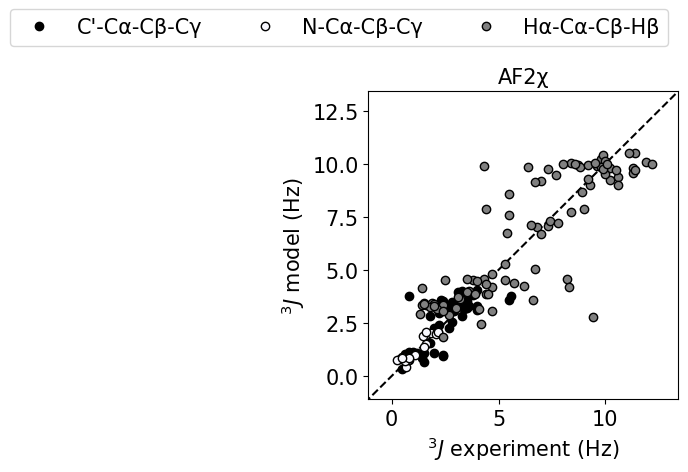

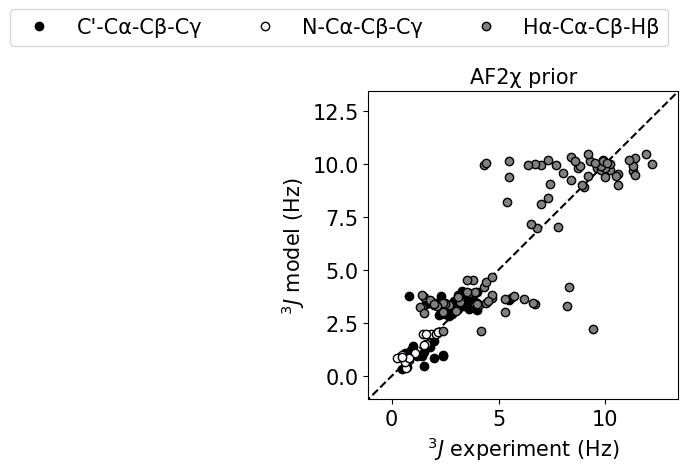

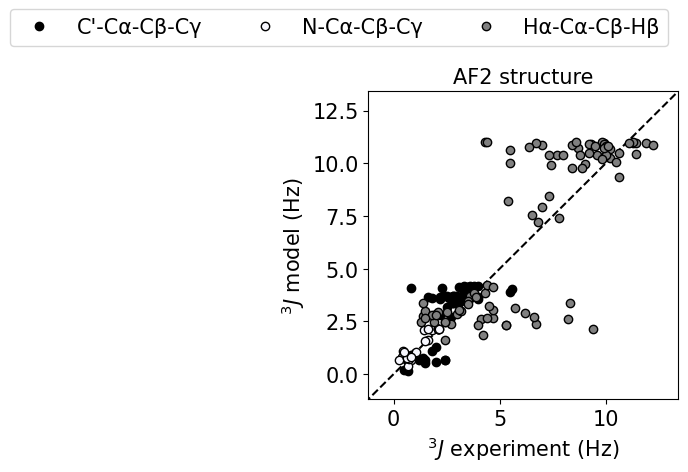

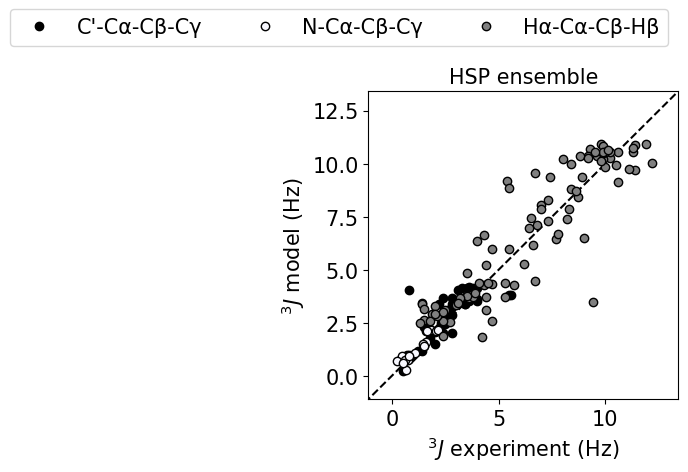

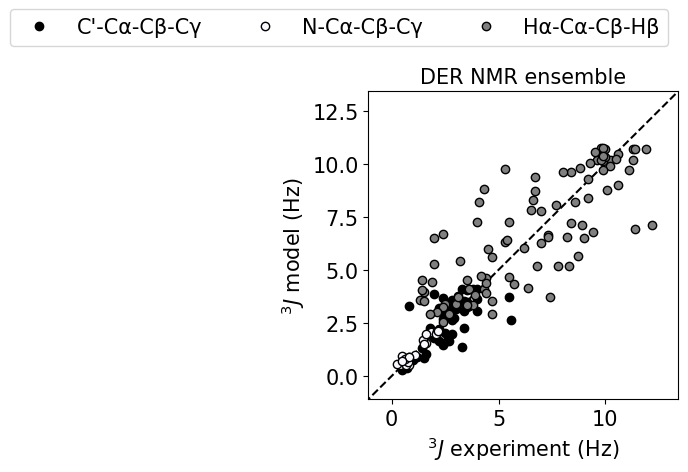

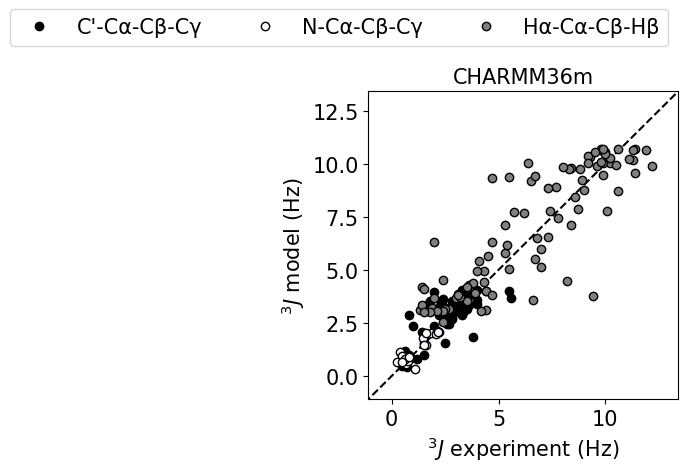

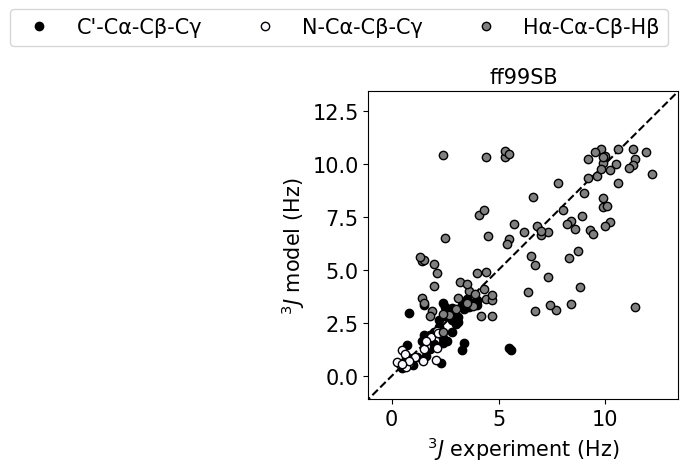

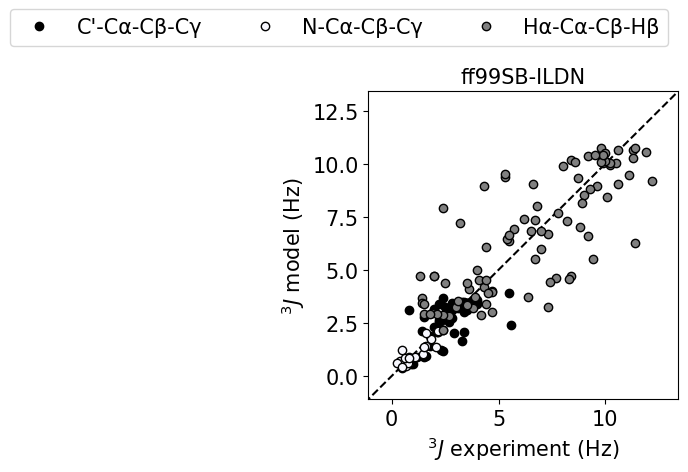

In [18]:
for ensemble_type in j3_results_arrs_C_CA_CB_CG.keys():
    make_plot(np.array(exp_j3_C_CA_CB_CG['exp']), np.array(exp_j3_N_CA_CB_CG['exp']), np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_C_CA_CB_CG[ensemble_type], j3_results_arrs_N_CA_CB_CG[ensemble_type], j3_results_arrs_HA_CA_CB_HB[ensemble_type], plot_names_dict[ensemble_type], f'../../figures/ubq_{ensemble_type}_jcouplings.pdf')

# Plot RMSEs split by dihedral type

In [19]:
import seaborn as sns

In [20]:
def plot_boxplot_with_points(*args, colors=None,labels=None, title=None):
    """
    Plots a boxplot with raw points underneath for each list passed.
    
    Parameters:
        *args: Each argument is a list or array of points.
        labels (list): Optional, a list of labels corresponding to each series.
        title (str): Optional, title for the plot.
    """
    
    # Create the figure and axis
    plt.figure(figsize=(10, 6))
    meanprops = {'color': 'red', 'linewidth': 20}
    # Plot the boxplot
    sns.boxplot(data=args, width=0.2, color='white',showmeans=True, meanprops=meanprops)

    for i, data in enumerate(args):
        # Add jitter to avoid points overlapping
        x = np.random.normal(i+0.3, 0.04, size=len(data))

        # Plot the raw data points
        if colors:
            for j, (x_val, y_val) in enumerate(zip(x, data)):
                plt.scatter(x_val, y_val, color=colors[j], alpha=0.7,edgecolor='w')
        else:
            plt.plot(x, data, 'r.', alpha=0.5)
    #plt.ylim(-0.01,1)
    plt.ylabel(r'MSE')
    plt.grid(axis='y',alpha=0.2,zorder=-200)
    # Add labels if provided
    if labels:
        plt.xticks(range(len(args)), labels)
    
    # Add title if provided
    if title:
        plt.title(title)

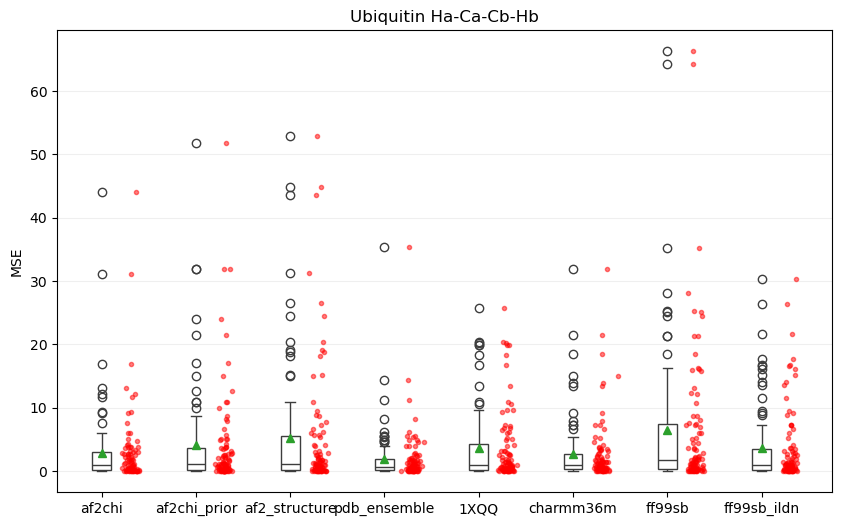

In [21]:
MSE_arr = []
labels = []

for ensemble_type in j3_results_arrs_HA_CA_CB_HB.keys():
    MSE = np.square(j3_results_arrs_HA_CA_CB_HB[ensemble_type]-np.array(exp_j3_HA_CA_CB_HB['exp']))
    MSE_arr.append(MSE)
    labels.append(ensemble_type)

plot_boxplot_with_points(*MSE_arr, labels=labels, title='Ubiquitin Ha-Ca-Cb-Hb')


af2chi 1.7097533000845093 0.18647168883431245
af2chi_prior 2.0166976109401578 0.20412383284843724
af2_structure 2.2994856561876826 0.22740506014863743
pdb_ensemble 1.398490857833801 0.15615278121138135
1XQQ 1.9027460728949595 0.1541175683957557
charmm36m 1.648333552589815 0.15752708502682122
ff99sb 2.538325791951647 0.2335751858155344
ff99sb_ildn 1.9166354124735947 0.16565133502739104


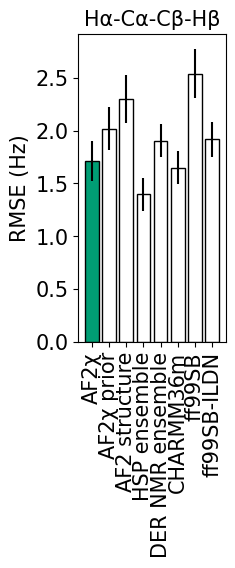

In [22]:
#Plotting
RMSE_arr = []
RMSE_err_arr = []
tick_labels = []
for ensemble_type in j3_results_arrs_HA_CA_CB_HB.keys():

    RMSE = root_mean_squared_error(np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_HA_CA_CB_HB[ensemble_type])
    RMSE_arr.append(root_mean_squared_error(np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_HA_CA_CB_HB[ensemble_type]))

    bootstrap_result = bootstrap((np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_HA_CA_CB_HB[ensemble_type]), root_mean_squared_error, vectorized=False, paired=True)    
    RMSE_err = bootstrap_result.standard_error
    RMSE_err_arr.append(RMSE_err)

    tick_labels.append(plot_names_dict[ensemble_type])

    print(ensemble_type, RMSE, RMSE_err)

x = np.arange(len(RMSE_arr))

fig = plt.figure(figsize=(1.9,4))

plt.bar(x, RMSE_arr, yerr=RMSE_err_arr, edgecolor='black', tick_label=tick_labels, color=[*['#009E74'], *['white']*len(RMSE_arr)])
#plt.axhline(RMSE_arr[0], ls='--', c='k')

plt.title('Hα-Cα-Cβ-Hβ', fontsize=15)

plt.ylabel('RMSE (Hz)', fontsize=15)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.savefig(f'../../figures/ubq_RMSEjcouplings_HA_CA_CB_HB_bar.pdf', bbox_inches='tight')

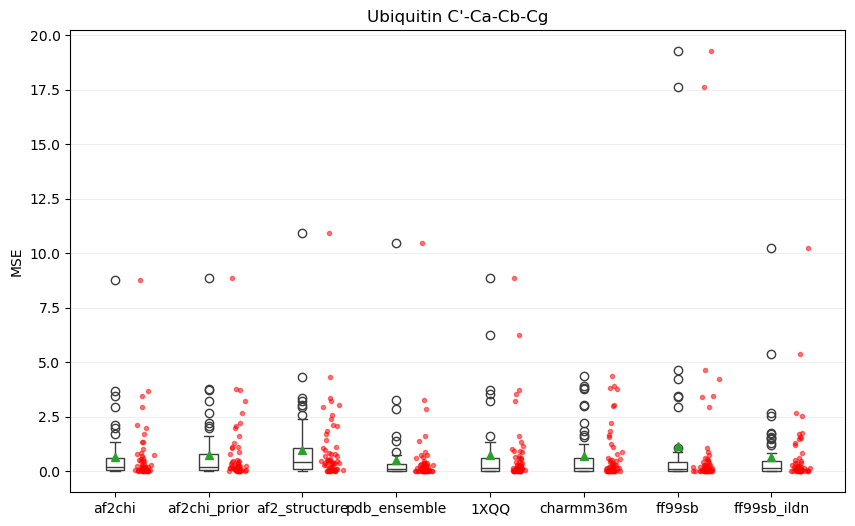

In [23]:
MSE_arr = []
labels = []

for ensemble_type in j3_results_arrs_C_CA_CB_CG.keys():
    MSE = np.square(j3_results_arrs_C_CA_CB_CG[ensemble_type]-np.array(exp_j3_C_CA_CB_CG['exp']))
    MSE_arr.append(MSE)
    labels.append(ensemble_type)

plot_boxplot_with_points(*MSE_arr, labels=labels, title='Ubiquitin C\'-Ca-Cb-Cg')


af2chi 0.8179635509965261 0.10910984062023502
af2chi_prior 0.8668944321763665 0.10835537220292552
af2_structure 0.9954036263912583 0.11086451257377579
pdb_ensemble 0.7062672552114895 0.1358662394221598
1XQQ 0.8488272196263581 0.12192632438761582
charmm36m 0.83310601293771 0.0911210479770412
ff99sb 1.0659556292401535 0.21943400977195507
ff99sb_ildn 0.8186306495305908 0.12604855687002303


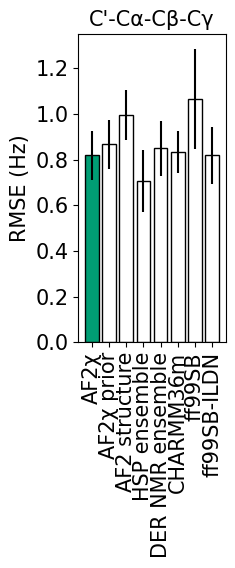

In [24]:
#Plotting
RMSE_arr = []
RMSE_err_arr = []
tick_labels = []
for ensemble_type in j3_results_arrs_C_CA_CB_CG.keys():
    RMSE = root_mean_squared_error(np.array(exp_j3_C_CA_CB_CG['exp']), j3_results_arrs_C_CA_CB_CG[ensemble_type])
    RMSE_arr.append(root_mean_squared_error(np.array(exp_j3_C_CA_CB_CG['exp']), j3_results_arrs_C_CA_CB_CG[ensemble_type]))
        
    bootstrap_result = bootstrap((np.array(exp_j3_C_CA_CB_CG['exp']), j3_results_arrs_C_CA_CB_CG[ensemble_type]), root_mean_squared_error, vectorized=False, paired=True)    
    RMSE_err = bootstrap_result.standard_error
    RMSE_err_arr.append(RMSE_err)

    tick_labels.append(plot_names_dict[ensemble_type])

    print(ensemble_type, RMSE, RMSE_err)

x = np.arange(len(RMSE_arr))

fig = plt.figure(figsize=(1.9,4))

plt.bar(x, RMSE_arr, yerr=RMSE_err_arr, edgecolor='black', tick_label=tick_labels, color=[*['#009E74'], *['white']*len(RMSE_arr)])
#plt.axhline(RMSE_arr[0], ls='--', c='k')

plt.title('C\'-Cα-Cβ-Cγ', fontsize=15)

plt.ylabel('RMSE (Hz)', fontsize=15)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.savefig(f'../../figures/ubq_RMSEjcouplings_C_CA_CB_CG_bar.pdf', bbox_inches='tight')

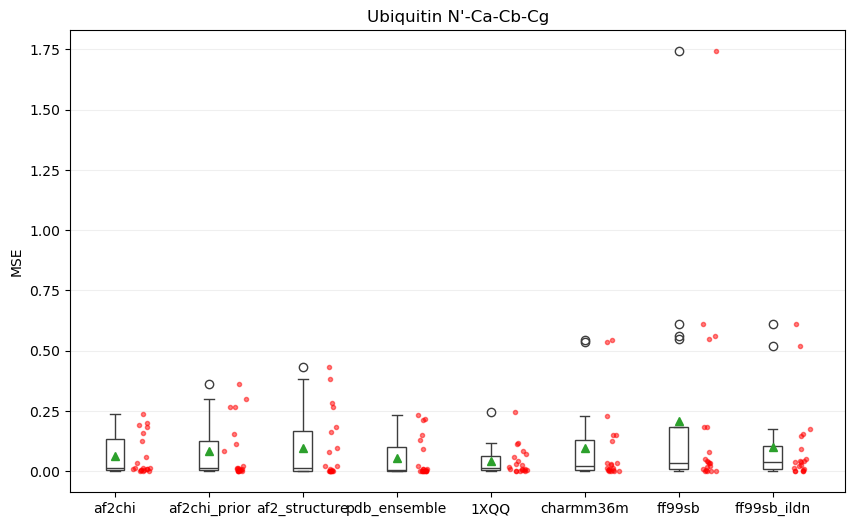

In [25]:
MSE_arr = []
labels = []

for ensemble_type in j3_results_arrs_N_CA_CB_CG.keys():
    MSE = np.square(j3_results_arrs_N_CA_CB_CG[ensemble_type]-np.array(exp_j3_N_CA_CB_CG['exp']))
    MSE_arr.append(MSE)
    labels.append(ensemble_type)

plot_boxplot_with_points(*MSE_arr, labels=labels, title='Ubiquitin N\'-Ca-Cb-Cg')


af2chi 0.2514598804739741 0.036699152931641714
af2chi_prior 0.2861127045583707 0.04704802458538176
af2_structure 0.3120154048062784 0.04931792832097159
pdb_ensemble 0.2333791235262247 0.04071444607481571
1XQQ 0.2054276115596005 0.03257155260693884
charmm36m 0.30871698351237264 0.05972534519774272
ff99sb 0.45586182116952934 0.10117227044464902
ff99sb_ildn 0.31378336475982915 0.059956486688361385


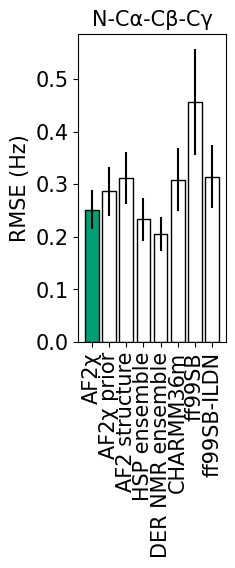

In [26]:
#Plotting
RMSE_arr = []
RMSE_err_arr = []
tick_labels = []
for ensemble_type in j3_results_arrs_N_CA_CB_CG.keys():
    RMSE = root_mean_squared_error(np.array(exp_j3_N_CA_CB_CG['exp']), j3_results_arrs_N_CA_CB_CG[ensemble_type])
    RMSE_arr.append(root_mean_squared_error(np.array(exp_j3_N_CA_CB_CG['exp']), j3_results_arrs_N_CA_CB_CG[ensemble_type]))
        
    bootstrap_result = bootstrap((np.array(exp_j3_N_CA_CB_CG['exp']), j3_results_arrs_N_CA_CB_CG[ensemble_type]), root_mean_squared_error, vectorized=False, paired=True)    
    RMSE_err = bootstrap_result.standard_error
    RMSE_err_arr.append(RMSE_err)

    tick_labels.append(plot_names_dict[ensemble_type])

    print(ensemble_type, RMSE, RMSE_err)

x = np.arange(len(RMSE_arr))

fig = plt.figure(figsize=(1.9,4))

plt.bar(x, RMSE_arr, yerr=RMSE_err_arr, edgecolor='black', tick_label=tick_labels, color=[*['#009E74'], *['white']*len(RMSE_arr)])
#plt.axhline(RMSE_arr[0], ls='--', c='k')

plt.title('N-Cα-Cβ-Cγ', fontsize=15)

plt.ylabel('RMSE (Hz)', fontsize=15)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.savefig(f'../../figures/ubq_RMSEjcouplings_N_CA_CB_CG_bar.pdf', bbox_inches='tight')